In [83]:
!pip install tensorflow==2.16.1 opencv-python matplotlib

In [86]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [148]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [149]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [6]:
# http://vis-www.cs.umass.edu/lfw/
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

tar: Error opening archive: Failed to open 'lfw.tgz'


In [11]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'lfw'

In [88]:
# Import uuid library to generate unique image names
import uuid

In [13]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\d9649a96-3440-11ef-be1b-60452e6c644c.jpg'

In [10]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

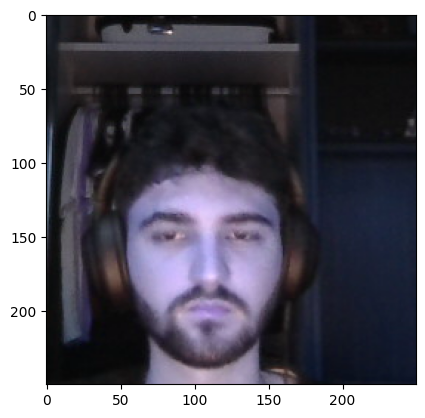

In [14]:
plt.imshow(frame[:250,:250, :])

In [15]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '\\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH + '\\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH + '\\*.jpg').take(3000)

In [16]:
dir_test = anchor.as_numpy_iterator()

In [17]:
print(dir_test.next())

b'data\\anchor\\e3e406d0-325c-11ef-b24d-60452e6c644c.jpg'


In [89]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [19]:
img = preprocess('data\\anchor\\e1b4ea4c-325c-11ef-a448-60452e6c644c.jpg')

In [20]:
img.numpy().max() 

1.0

In [21]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

In [22]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [23]:
samples = data.as_numpy_iterator()

In [24]:
example = samples.next()

In [25]:
example

(b'data\\anchor\\e0b05f51-325c-11ef-a047-60452e6c644c.jpg',
 b'data\\positive\\38157f0e-325d-11ef-bbad-60452e6c644c.jpg',
 1.0)

In [26]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [27]:
res = preprocess_twin(*example)

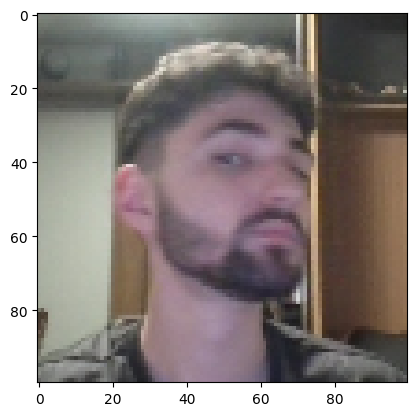

In [28]:
plt.imshow(res[1])

In [29]:
res[2]

1.0

In [30]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [31]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [32]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [33]:
inp = Input(shape=(100,100,3), name='input_image')

In [34]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [35]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [36]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)

In [37]:
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [38]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)

In [39]:
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [40]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)

In [41]:
f1 = Flatten()(c4)

In [42]:
d1 = Dense(4096, activation='sigmoid')(f1)

In [43]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [44]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [152]:
# Define the embedding model
def make_embedding():
    inp = Input(shape=(100, 100, 3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=inp, outputs=d1, name='embedding')

In [160]:
sample_input = tf.random.normal([1, 100, 100, 3])
sample_output = embedding(sample_input)
print(type(sample_output))  # Ensure this is a tensor
print(sample_output.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 4096)


In [153]:
embedding = make_embedding()

In [154]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [171]:
# Define the L1Dist layer
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [172]:
l1 = L1Dist()

In [173]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

In [198]:
# Build the Siamese model
def make_siamese_model():
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100, 100, 3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100, 100, 3))
    
    # Get the embeddings
    inp_embedding = embedding(input_image)
    val_embedding = embedding(validation_image)
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(inp_embedding, val_embedding)
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [199]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_30 (L1Dist)           │ (None, 4096)              │               0 │ embedding[6][0],           │
│                               │                           │                 │ embedding[7][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_16 (Dense)              │ (None, 1)                 │           4,097 │ l1_dist_30[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [200]:
anchor_image = tf.random.normal([1, 100, 100, 3])
validation_image = tf.random.normal([1, 100, 100, 3])

In [201]:
inp_embedding = embedding(anchor_image)
val_embedding = embedding(validation_image)

In [202]:
print(type(inp_embedding))
print(type(val_embedding))

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [203]:
siamese_layer = L1Dist()

In [204]:
distances = siamese_layer(inp_embedding, val_embedding)
print(distances)

tf.Tensor(
[[2.2563040e-03 4.3547153e-04 1.5428960e-02 ... 6.6876411e-05
  1.0818243e-05 1.3683438e-03]], shape=(1, 4096), dtype=float32)


In [205]:
classifier = Dense(1, activation='sigmoid')(distances)
print(classifier)

tf.Tensor([[0.49797916]], shape=(1, 1), dtype=float32)


In [206]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

ValueError: When providing `inputs` as a list/tuple, all values in the list/tuple must be KerasTensors. Received: inputs=[<KerasTensor shape=(None, 100, 100, 3), dtype=float32, sparse=None, name=input_img>, <tf.Tensor: shape=(1, 100, 100, 3), dtype=float32, numpy=
array([[[[ 1.2591593 ,  0.45654592,  0.6693149 ],
         [-0.8182874 , -0.6587242 , -0.9067786 ],
         [ 0.62274116, -0.23817472,  0.2928916 ],
         ...,
         [-0.8922826 , -1.4133837 , -0.21603173],
         [-0.11572976, -0.3872468 ,  0.7050162 ],
         [ 0.74393404,  0.43424284,  1.1675513 ]],

        [[ 0.71112216,  0.2948598 , -0.7096176 ],
         [-0.5105131 , -0.24168792,  0.12928759],
         [ 0.20335771, -0.7996762 ,  0.30073953],
         ...,
         [-0.74365246, -0.7333596 ,  0.38501742],
         [-0.7887186 ,  1.3384016 ,  0.67721725],
         [-1.9640101 , -0.15369889,  2.1215184 ]],

        [[ 1.1369089 ,  0.3989157 ,  0.7041198 ],
         [-2.2512877 ,  1.7346736 ,  0.69624335],
         [-0.60476506,  0.5171417 , -0.17734365],
         ...,
         [-1.1201261 , -0.35989478,  0.60141814],
         [-0.74133784, -1.22556   , -0.3514383 ],
         [-0.11735547, -0.6547384 ,  0.798513  ]],

        ...,

        [[ 0.03858487, -0.75726426, -1.1618413 ],
         [-0.1946323 ,  0.3988038 , -0.465001  ],
         [-1.3813792 , -1.1033218 ,  0.9538245 ],
         ...,
         [-1.589737  ,  2.828876  ,  0.3644696 ],
         [-1.0259154 , -0.67954177,  0.11888021],
         [ 1.138849  ,  0.35774392,  0.07044908]],

        [[-0.12522691,  1.3091054 ,  0.01385503],
         [ 0.26932576, -0.69206643,  1.8535066 ],
         [-0.60098726,  1.5569421 , -0.36584604],
         ...,
         [-0.69437325, -0.5115387 , -0.993971  ],
         [ 0.70412695,  0.59586483,  0.23746073],
         [-0.08556981,  1.4212711 , -1.9241496 ]],

        [[-0.18694109,  1.1861752 , -0.87157273],
         [-0.41722414, -0.0417203 , -0.3200094 ],
         [-1.8267825 , -0.9643586 ,  0.01089301],
         ...,
         [-0.36918342,  1.0750924 ,  1.8994918 ],
         [ 0.16132058,  1.0462391 ,  0.9465825 ],
         [-0.9206854 , -0.27790865,  0.75077873]]]], dtype=float32)>] including invalid value [[[[ 1.2591593   0.45654592  0.6693149 ]
   [-0.8182874  -0.6587242  -0.9067786 ]
   [ 0.62274116 -0.23817472  0.2928916 ]
   ...
   [-0.8922826  -1.4133837  -0.21603173]
   [-0.11572976 -0.3872468   0.7050162 ]
   [ 0.74393404  0.43424284  1.1675513 ]]

  [[ 0.71112216  0.2948598  -0.7096176 ]
   [-0.5105131  -0.24168792  0.12928759]
   [ 0.20335771 -0.7996762   0.30073953]
   ...
   [-0.74365246 -0.7333596   0.38501742]
   [-0.7887186   1.3384016   0.67721725]
   [-1.9640101  -0.15369889  2.1215184 ]]

  [[ 1.1369089   0.3989157   0.7041198 ]
   [-2.2512877   1.7346736   0.69624335]
   [-0.60476506  0.5171417  -0.17734365]
   ...
   [-1.1201261  -0.35989478  0.60141814]
   [-0.74133784 -1.22556    -0.3514383 ]
   [-0.11735547 -0.6547384   0.798513  ]]

  ...

  [[ 0.03858487 -0.75726426 -1.1618413 ]
   [-0.1946323   0.3988038  -0.465001  ]
   [-1.3813792  -1.1033218   0.9538245 ]
   ...
   [-1.589737    2.828876    0.3644696 ]
   [-1.0259154  -0.67954177  0.11888021]
   [ 1.138849    0.35774392  0.07044908]]

  [[-0.12522691  1.3091054   0.01385503]
   [ 0.26932576 -0.69206643  1.8535066 ]
   [-0.60098726  1.5569421  -0.36584604]
   ...
   [-0.69437325 -0.5115387  -0.993971  ]
   [ 0.70412695  0.59586483  0.23746073]
   [-0.08556981  1.4212711  -1.9241496 ]]

  [[-0.18694109  1.1861752  -0.87157273]
   [-0.41722414 -0.0417203  -0.3200094 ]
   [-1.8267825  -0.9643586   0.01089301]
   ...
   [-0.36918342  1.0750924   1.8994918 ]
   [ 0.16132058  1.0462391   0.9465825 ]
   [-0.9206854  -0.27790865  0.75077873]]]] of type <class 'tensorflow.python.framework.ops.EagerTensor'>

In [207]:
siamese_network.summary()

NameError: name 'siamese_network' is not defined